In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import time
import numpy as np
import defmod as dm
import defmod.multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.registrationdata as regdata
import defmod.hamiltonian_multishape as hamiltonian
from defmod.energyfunctional import EnergyFunctional_unconstrained, EnergyFunctional
from defmod import optimize
import defmod.save_res as results



torch.set_default_tensor_type(torch.DoubleTensor)

In [30]:
data1 = regdata.Nut_translated(source_transvec=[0.,0.], target_transvec=[-1.,0.], reflect_target=-1., undersample=2)
data1()
data2 = regdata.Nut_translated(source_transvec=[1.,1.5], target_transvec=[1.5,1.5], reflect_target=1., undersample=2)
data2()
source = [*data1.source, *data2.source]
target = [*data1.target, *data2.target]
module_list = [*data1.modules, *data2.modules]
reduce_background = False

<Figure size 432x288 with 0 Axes>

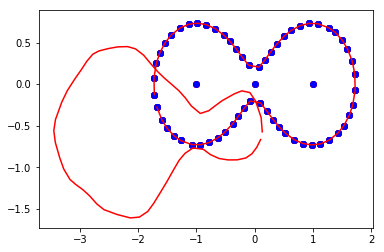

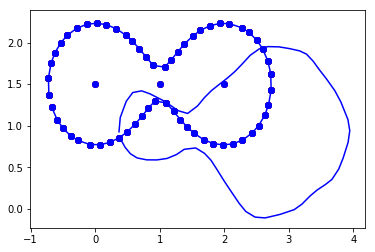

In [31]:
plt.figure()
c = ['r', 'b']
for i in range(2):
    plt.figure()
    plt.plot(source[i].detach().numpy()[:,0], source[i].detach().numpy()[:,1], c=c[i])
    for j in range(5):
        plt.scatter(module_list[i][j].manifold.gd.view(-1,2).detach().numpy()[:,0],module_list[i][j].manifold.gd.view(-1,2).detach().numpy()[:,1], c=c[i])

    plt.plot(target[i].detach().numpy()[:,0], target[i].detach().numpy()[:,1], c=c[i])


    for gd in module_list[i].manifold.gd:
        plt.scatter(gd.view(-1,2).detach().numpy()[:,0],gd.view(-1,2).detach().numpy()[:,1], c='r')
    for gd in module_list[i].manifold.gd:
        plt.scatter(gd.view(-1,2).detach().numpy()[:,0],gd.view(-1,2).detach().numpy()[:,1], c='b')

#plt.show()

<Figure size 432x288 with 0 Axes>

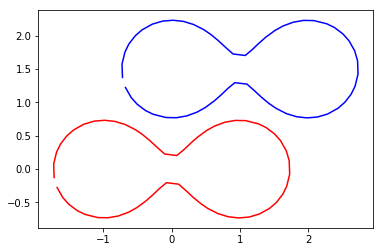

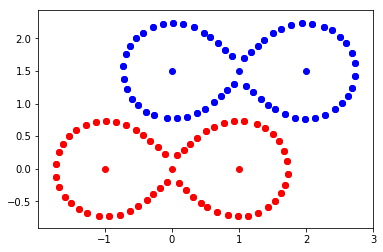

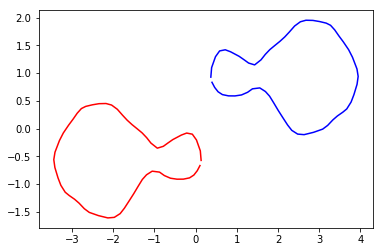

In [32]:
plt.figure()
c = ['r', 'b']

plt.figure()
for i in range(2):
    plt.plot(source[i].detach().numpy()[:,0], source[i].detach().numpy()[:,1], c=c[i])
    
plt.figure()
for i in range(2):
    for j in range(5):
        plt.scatter(module_list[i][j].manifold.gd.view(-1,2).detach().numpy()[:,0],module_list[i][j].manifold.gd.view(-1,2).detach().numpy()[:,1], c=c[i])

plt.figure()        
for i in range(2):
    plt.plot(target[i].detach().numpy()[:,0], target[i].detach().numpy()[:,1], c=c[i])

plt.show()

In [29]:
sigma_bg = 0.3
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

constr = dm.constraints.Identity_Silent()
H = dm.hamiltonian_multishape.Hamiltonian_multi(modules, constr)
def attach(modules, target):
    
    return sum([dm.attachement.VarifoldAttachement([1, 0.2])([modules.module_list[i][0].manifold.gd.view(-1,2)], [target[i]]) for i in range(2)])
E = EnergyFunctional_unconstrained(H.module, H, source, target, dim=2, gamma=1e-3, attach=attach)

In [13]:
attach(H.module, target)

tensor(25.8647, grad_fn=<AddBackward0>)

In [24]:
gd0_tensor = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(H.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)
    
    
gd0_tensor_init = gd0_tensor.clone()
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
X = [gd0_tensor, mom0_tensor]

from defmod import optimize
tic = time.time()
X[1], iter_states = optimize.BFGS(E, X, disp=True)(maxiter=500)
toc=time.time()

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


cost: 0.0 attach: 25.864663228610674
cost: 0.0 attach: 25.864663228610674
cost: 0.005308957846958976 attach: 9.999245592837358
cost: 0.005308957846958976 attach: 9.999245592837358
cost: 0.036348931383179205 attach: 28.68495011216663
cost: 0.036348931383179205 attach: 28.68495011216663
cost: 0.009418667222067334 attach: 4.701187663302756
cost: 0.009418667222067334 attach: 4.701187663302756
cost: 0.02803603136689733 attach: 28.2936810248287
cost: 0.02803603136689733 attach: 28.2936810248287
cost: 0.010056231513169681 attach: 4.314931039515215
cost: 0.010056231513169681 attach: 4.314931039515215
cost: 0.010083843236484626 attach: 3.7867937302055914
cost: 0.010083843236484626 attach: 3.7867937302055914
cost: 0.010020884290988206 attach: 2.819746328740443
cost: 0.010020884290988206 attach: 2.819746328740443
cost: 0.010307199737060306 attach: 4.062765388389602
cost: 0.010307199737060306 attach: 4.062765388389602
cost: 0.00999857412056355 attach: 2.5306188757696706
cost: 0.00999857412056355 a

In [26]:
toc-tic

835.7886412143707

In [43]:
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])
H.geodesic_controls()
save = results.Save_Results_MultiShape(H, source, target, E, iter_states=iter_states, time=toc-tic)

xlim = [-4.5, 5.5]
ylim = [-2.5,4.5]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


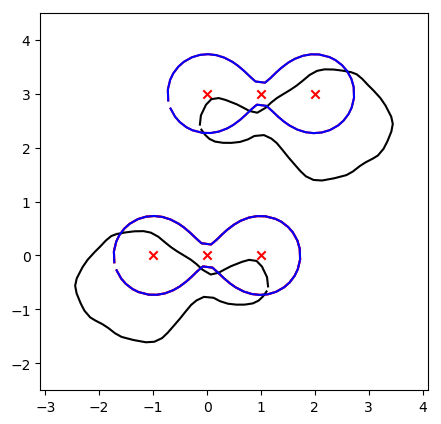

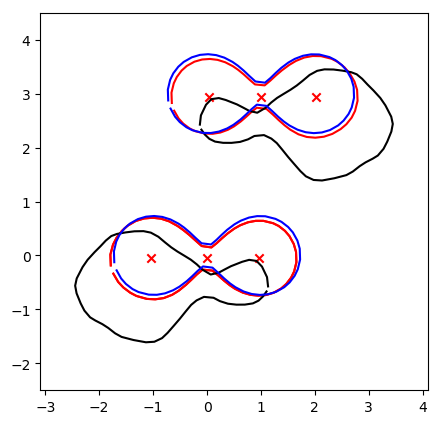

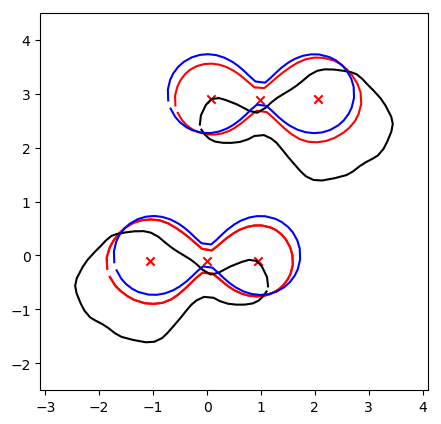

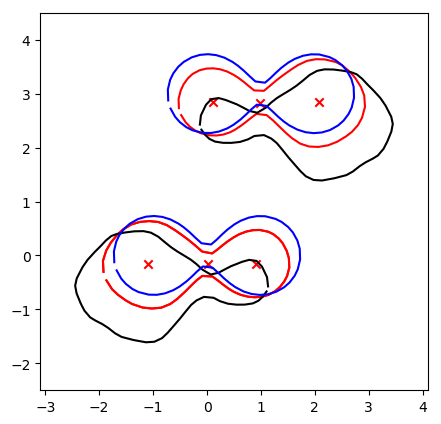

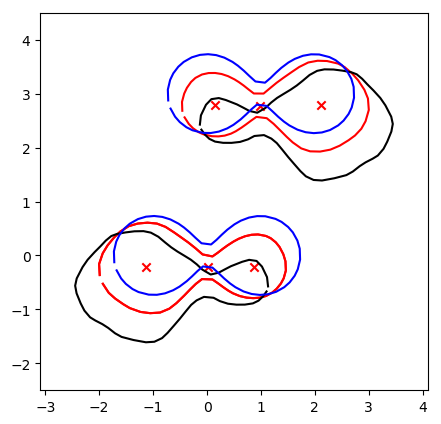

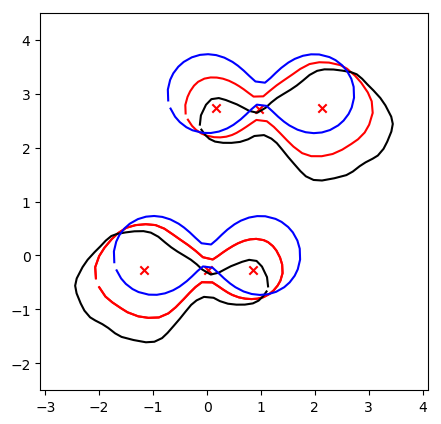

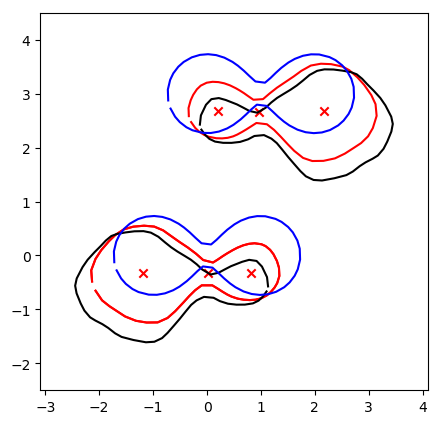

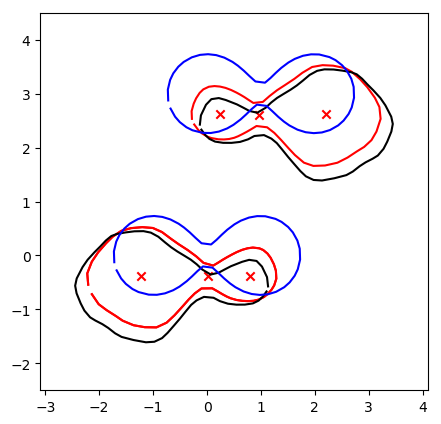

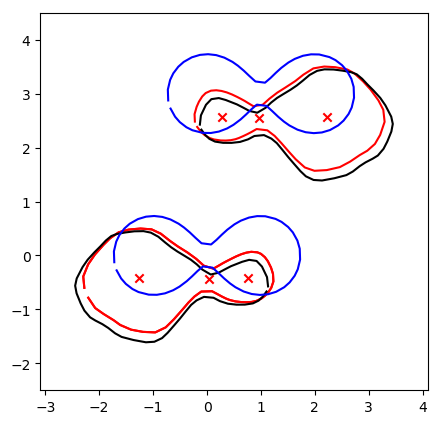

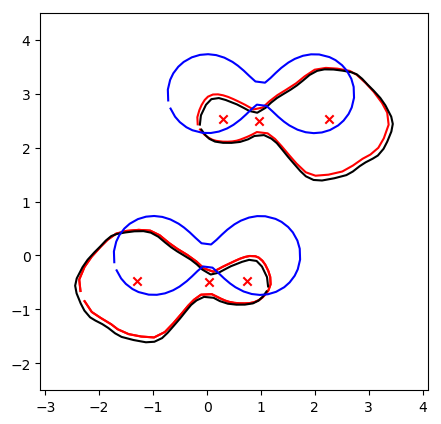

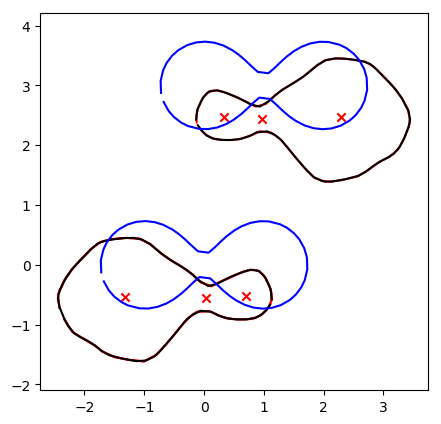

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape_silentpoints.py:221: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


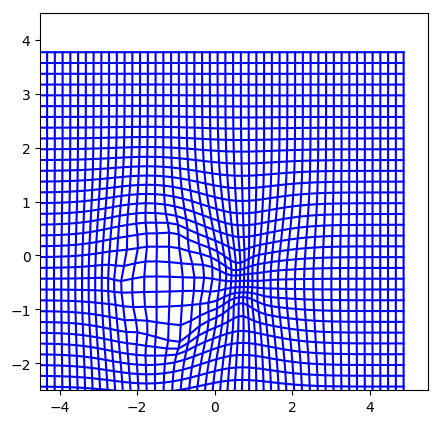

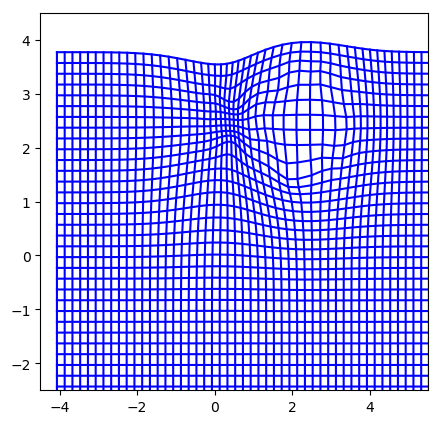

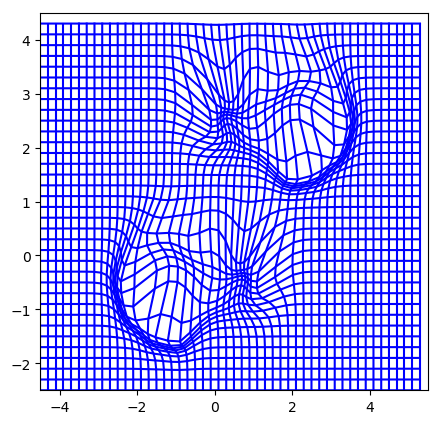

<Figure size 432x288 with 0 Axes>

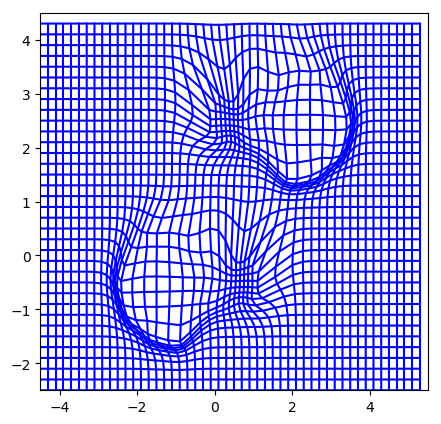

In [44]:
fig_states = save.fig_states(show=True, axeslim=[xlim, ylim], plot_gd=['plot', 'scatter', 'scatter', 'scatter', None])
fig_grid1, fig_grid2, fig_grid_bg, fig_multigrid = save.fig_grid(True)

save.save('../results/Nuts-Multi1/MultiShapeDefmod/', axeslim=[xlim, ylim], plot_gd=['plot', 'scatter', 'scatter', 'scatter', None])
plt.close('all')

In [41]:

gd0 = torch.cat([data1.modules[0][i].manifold.gd.clone() for i in [1,2,3]]).view(-1)
gd1= torch.cat([data2.modules[0][i].manifold.gd.clone() for i in [1,2,3]]).view(-1)

In [42]:
## LDDMM Multishape Module
sigma1 = 0.5
manifold1 = dm.manifold.Landmarks(2, len(source[0]), gd=source[0].view(-1))
silent1 = dm.deformationmodules.SilentPoints(manifold1.copy())
silent_gd0 = dm.deformationmodules.SilentPoints(dm.manifold.Landmarks(2, 3, gd=gd0))
trans1 = dm.deformationmodules.Translations(manifold1, sigma1)

mod1 = dm.deformationmodules.CompoundModule([silent1, silent_gd0, trans1])

sigma2 = 0.5
manifold2 = dm.manifold.Landmarks(2, len(source[1]), gd=source[1].view(-1))
silent2 = dm.deformationmodules.SilentPoints(manifold2.copy())
silent_gd1 = dm.deformationmodules.SilentPoints(dm.manifold.Landmarks(2, 3, gd=gd1))

trans2 = dm.deformationmodules.Translations(manifold2, sigma2)

mod2 = dm.deformationmodules.CompoundModule([silent2,silent_gd1, trans2])

module_list = [mod1, mod2]
sigma_bg = 0.2
multi_LDDMM = dm.multishape.MultiShapeModule(module_list, sigma_bg)

constr = dm.constraints.Identity_Silent()
H_multi_LDDMM = dm.hamiltonian_multishape.Hamiltonian_multi(multi_LDDMM, constr)

In [43]:
def attach(modules, target):
    
    return sum([dm.attachement.VarifoldAttachement([1, 0.2])([modules.module_list[i][0].manifold.gd.view(-1,2)], [target[i]]) for i in range(2)])


In [44]:
Energy_multi_LDDMM = EnergyFunctional(multi_LDDMM, H_multi_LDDMM, constr, source, target, dim=2, gamma=1e-3, attach = attach)
gd0 = torch.cat(multi_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(multi_LDDMM.manifold.unroll_cotan())
X_multi_LDDMM = [gd0, mom0]

tic=time.time()
X_multi_LDDMM[1], iter_states = dm.optimize.BFGS(Energy_multi_LDDMM, X_multi_LDDMM, disp=True)(maxiter=500)
toc=time.time()

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


cost: 0.0 attach: 38.998647609359494
cost: 0.0 attach: 38.998647609359494
cost: 0.0032728344437072585 attach: 25.881313069701218
cost: 0.0032728344437072585 attach: 25.881313069701218
cost: 4.353691349195631e+34 attach: 1.8201279370781e+36
cost: 4.353691349195631e+34 attach: 1.8201279370781e+36
cost: 0.008209859431278681 attach: 17.74529798337087
cost: 0.008209859431278681 attach: 17.74529798337087
cost: 2.1842215148212013e+30 attach: 1.6395373017318417e+32
cost: 2.1842215148212013e+30 attach: 1.6395373017318417e+32
cost: 325185734.7896252 attach: 27.936743242702867
cost: 325185734.7896252 attach: 27.936743242702867
cost: 0.009291953300621774 attach: 16.727157709564075
cost: 0.009291953300621774 attach: 16.727157709564075
cost: 0.02762883838891368 attach: 15.468601865442807
cost: 0.02762883838891368 attach: 15.468601865442807
cost: 0.009188675436695916 attach: 16.697717768523184
cost: 0.009188675436695916 attach: 16.697717768523184
cost: 3.7902775168050114e+40 attach: 1.131872694639606

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


cost: 3.7902775168050114e+40 attach: 1.1318726946396068e+43
cost: 1.0472677950117491e+27 attach: 7.303236469003048e+28
cost: 946643466967702.1 attach: 526724945139.3992
cost: 1329606138.1072428 attach: 45.73718002463258
cost: 1209885.2064337218 attach: 19.592364214827192
cost: 1.1159908984232345 attach: 15.434345110609026
cost: 1.1159908984232345 attach: 15.434345110609026
cost: 1604.5174239048804 attach: 15.436423492704098
cost: 15.27931802194152 attach: 15.478552054019111
cost: 2.6814688311195027 attach: 15.22761265426973
cost: 1.2544459180149654 attach: 15.487039983098938
cost: 1.1159908984232345 attach: 15.434345110609026
cost: 1.1159908984232345 attach: 15.434345110609026
         Current function value: 16.706906
         Iterations: 2
         Function evaluations: 24
         Gradient evaluations: 13


In [45]:
H_multi_LDDMM.module.manifold.fill_gd(X_multi_LDDMM[0])
H_multi_LDDMM.module.manifold.fill_cotan(X_multi_LDDMM[1])
H_multi_LDDMM.geodesic_controls()
save = results.Save_Results_MultiShape(H_multi_LDDMM, source, target, Energy_multi_LDDMM, time=toc-tic, iter_states=iter_states)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


In [48]:
xlim = [-3, 4]
ylim = [-2,4]
d = [0.1, 0.1]
_ = save.gridpoints(xlim, ylim, d)
#save.fig_grid(True)

save.save('../results/Nuts-Multi1/MultiShapeLDDMM/', axeslim=[xlim, ylim], plot_gd=['plot', 'scatter', None])
plt.close('all')

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape_silentpoints.py:221: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


In [58]:
toc-tic


864.5387501716614

In [49]:
## LDDMM Module

manifold1 = dm.manifold.Landmarks(2, len(source[0]), gd=source[0].view(-1))
manifold2 = dm.manifold.Landmarks(2, len(source[1]), gd=source[1].view(-1))

module_LDDMM = dm.deformationmodules.CompoundModule([*[dm.deformationmodules.Translations(man, sigma=0.3) for man in [manifold1, manifold2]], silent_gd0, silent_gd1])
H_LDDMM = dm.hamiltonian.Hamiltonian([module_LDDMM])

def attach(modules, target): 
    return sum([dm.attachement.VarifoldAttachement([1, 0.2])([modules.module_list[i].manifold.gd.view(-1,2)], [target[i]]) for i in range(2)])


reg_param = 1e-3
Energy_LDDMM = EnergyFunctional_unconstrained(module_LDDMM, H_LDDMM, source, target, dim=2, gamma=reg_param, attach=attach)
gd0 = torch.cat(module_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(module_LDDMM.manifold.unroll_cotan())
X_LDDMM = [gd0, mom0]

tic=time.time()
X_LDDMM[1], iter_states = dm.optimize.BFGS(Energy_LDDMM, X_LDDMM, disp=True)(maxiter=2500)
toc=time.time()

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.0 attach: 38.998647609359494
cost: 0.0 attach: 38.998647609359494
cost: 0.0031811301325177068 attach: 37.57002396605616
cost: 0.0031811301325177068 attach: 37.57002396605616
cost: 2.4140836062904556e-05 attach: 37.19360186246416
cost: 2.4140836062904556e-05 attach: 37.19360186246416
cost: 0.00017427143805638754 attach: 33.68097111273934
cost: 0.00017427143805638754 attach: 33.68097111273934
cost: 0.00236641452812784 attach: 23.53644511403291
cost: 0.00236641452812784 attach: 23.53644511403291
cost: 0.014121564215290015 attach: 27.307383168192537
cost: 0.014121564215290015 attach: 27.307383168192537
cost: 0.006649235765366539 attach: 14.706533485481527
cost: 0.006649235765366539 attach: 14.706533485481527
cost: 0.016937371154256732 attach: 248.3280083321803
cost: 0.016937371154256732 attach: 248.3280083321803
cost: 0.009195539871478996 attach: 12.01228517115124
cost: 0.009195539871478996 attach: 12.01228517115124
cost: 0.012258780883318752 attach: 11.318871736075558
cost: 0.0122

cost: 0.019562119007103466 attach: 2.1173534355568115
cost: 0.019562119007103515 attach: 2.0483128028940403
cost: 0.019562119007103515 attach: 2.0483128028940403
cost: 0.019562119007103515 attach: 2.0483128028940403
cost: 0.019562119007103515 attach: 2.0483128028940403
cost: 0.01956211900710347 attach: 2.1085244902510034
cost: 0.01956211900710347 attach: 2.1085244902510034
cost: 0.019562119007103515 attach: 2.0483128028940403
cost: 0.019562119007103515 attach: 2.0483128028940403
cost: 0.019562119007103515 attach: 2.0483128028940403
cost: 0.019562119007103515 attach: 2.0483128028940403
cost: 0.01956211900710345 attach: 856238.2243135662
cost: 0.01956211900710345 attach: 856238.2243135662
cost: 0.019562119007103515 attach: 2.0483128028940403
cost: 0.019562119007103515 attach: 2.0483128028940403


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.01951849303370795 attach: 2.0775753143588513
cost: 0.019545481988272634 attach: 2.0846772541120266
cost: 0.01955821958365841 attach: 1.9693607784219402
cost: 0.01955821958365841 attach: 1.9693607784219402


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.019479388383800908 attach: 627.4316395621674
cost: 0.019479388383800908 attach: 627.4316395621674
cost: 0.01955821914951136 attach: 2.0873010304144035
cost: 0.01955821914951136 attach: 2.0873010304144035
cost: 0.019558219583657867 attach: 2.195633575526191
cost: 0.019558219583657867 attach: 2.195633575526191
cost: 0.01955821958365841 attach: 1.9693607784219402
cost: 0.01955821958365841 attach: 1.9693607784219402
cost: 0.01955821958365841 attach: 1.9693607784219402
cost: 0.01955821958365841 attach: 1.9693607784219402
cost: 0.019558219583658186 attach: 1.9758129885284141
cost: 0.019558219583658186 attach: 1.9758129885284141
cost: 0.01955821958365841 attach: 1.9693607784219402
cost: 0.01955821958365841 attach: 1.9693607784219402
cost: 0.01955821958365841 attach: 1.9693607784219402
cost: 0.01955821958365841 attach: 1.9693607784219402
cost: 0.01955821958365828 attach: 2.0564734799346436
cost: 0.01955821958365828 attach: 2.0564734799346436
cost: 0.01955821958365841 attach: 1.96936077

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.019479388383800908 attach: 627.4316395621674
cost: 0.019517129446596174 attach: 2.385813832249715
cost: 0.0195305296417378 attach: 2.1783030992804466
cost: 0.019555350024366095 attach: 2.0284645428902177
cost: 0.019556782909113044 attach: 2.0049320141193423
cost: 0.019557500772660944 attach: 2.098761430222238
cost: 0.019557860059728496 attach: 80190.57186755777
cost: 0.019558039792085598 attach: 2.0860828707000234
cost: 0.0195580997167287 attach: 2.089062041716897
cost: 0.019558159646903744 attach: 2.0810939014239747
cost: 0.019558189614458633 attach: 2.087851408888266
cost: 0.019558204598852914 attach: 2.09701030732351
         Current function value: 1.988919
         Iterations: 43
         Function evaluations: 113
         Gradient evaluations: 99


In [50]:
toc-tic

102.26515865325928

In [56]:
H_LDDMM.module.manifold.fill_gd(X_LDDMM[0])
H_LDDMM.module.manifold.fill_cotan(X_LDDMM[1])
H_LDDMM.geodesic_controls()
save = results.Save_Results_SingleShape(H_LDDMM, source, target, Energy_LDDMM, time=toc-tic, iter_states=iter_states)

xlim = [-3, 4]
ylim = [-2,4]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)
#save.fig_grid(True)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


In [58]:
save.save('../results/Nuts-Multi/LDDMM/',  axeslim=[*xlim, *ylim], plot_gd=['plot', 'plot', 'scatter', 'scatter', None])
plt.close('all')

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


In [73]:
toc-tic

168.45728707313538

In [53]:
H_LDDMM.module.manifold.gd

[tensor([-1.7193, -0.1256, -1.7263,  0.0754, -1.6834,  0.2559, -1.6253,  0.3769,
         -1.5327,  0.4992, -1.4322,  0.5886, -1.2814,  0.6741, -1.1307,  0.7193,
         -0.9799,  0.7320, -0.8291,  0.7149, -0.6784,  0.6679, -0.5276,  0.5893,
         -0.4271,  0.5185, -0.3189,  0.4271, -0.2132,  0.3266, -0.1018,  0.2261,
          0.0754,  0.2036,  0.1759,  0.2889,  0.2764,  0.3867,  0.3769,  0.4779,
          0.5099,  0.5779,  0.6281,  0.6453,  0.7789,  0.7027,  0.9296,  0.7295,
          1.0804,  0.7269,  1.2702,  0.6784,  1.3819,  0.6225,  1.5045,  0.5276,
          1.5921,  0.4271,  1.6758,  0.2764,  1.7193,  0.1256,  1.7263, -0.0754,
          1.6834, -0.2559,  1.6253, -0.3769,  1.5327, -0.4992,  1.4322, -0.5886,
          1.2814, -0.6741,  1.1307, -0.7193,  0.9799, -0.7320,  0.8291, -0.7149,
          0.6784, -0.6679,  0.5276, -0.5893,  0.4271, -0.5185,  0.3189, -0.4271,
          0.2132, -0.3266,  0.1018, -0.2261, -0.0754, -0.2036, -0.1759, -0.2889,
         -0.2764, -0.3867, -

In [67]:
## Unconstrained Compound Module

module_compound = dm.deformationmodules.CompoundModule([*data1.modules, *data2.modules])
H_compound = dm.hamiltonian.Hamiltonian(module_compound)

def attach(modules, target): 
    return sum([dm.attachement.VarifoldAttachement([1, 0.2])([modules.module_list[5*i].manifold.gd.view(-1,2)], [target[i]]) for i in range(2)])

Energy_compound = EnergyFunctional_unconstrained(module_compound, H_compound, source, target, dim=2, gamma=1e-3, attach=attach)
gd0_c = torch.cat(module_compound.manifold.unroll_gd())
mom0_c = torch.cat(module_compound.manifold.unroll_cotan())
X_compound = [gd0_c, mom0_c]

In [63]:
def attach(modules, target): 
    return sum([dm.attachement.VarifoldAttachement([1, 0.2])([modules.module_list[5*i].manifold.gd.view(-1,2)], [target[i]]) for i in range(2)])

attach(H_compound.module, target)

tensor(38.9986, grad_fn=<AddBackward0>)

In [68]:
H.module.manifold.gd

[[tensor([-1.7193, -0.1256, -1.7263,  0.0754, -1.6834,  0.2559, -1.6253,  0.3769,
          -1.5327,  0.4992, -1.4322,  0.5886, -1.2814,  0.6741, -1.1307,  0.7193,
          -0.9799,  0.7320, -0.8291,  0.7149, -0.6784,  0.6679, -0.5276,  0.5893,
          -0.4271,  0.5185, -0.3189,  0.4271, -0.2132,  0.3266, -0.1018,  0.2261,
           0.0754,  0.2036,  0.1759,  0.2889,  0.2764,  0.3867,  0.3769,  0.4779,
           0.5099,  0.5779,  0.6281,  0.6453,  0.7789,  0.7027,  0.9296,  0.7295,
           1.0804,  0.7269,  1.2702,  0.6784,  1.3819,  0.6225,  1.5045,  0.5276,
           1.5921,  0.4271,  1.6758,  0.2764,  1.7193,  0.1256,  1.7263, -0.0754,
           1.6834, -0.2559,  1.6253, -0.3769,  1.5327, -0.4992,  1.4322, -0.5886,
           1.2814, -0.6741,  1.1307, -0.7193,  0.9799, -0.7320,  0.8291, -0.7149,
           0.6784, -0.6679,  0.5276, -0.5893,  0.4271, -0.5185,  0.3189, -0.4271,
           0.2132, -0.3266,  0.1018, -0.2261, -0.0754, -0.2036, -0.1759, -0.2889,
          -0.276

In [69]:
tic=time.time()
X_compound[1], iter_states = dm.optimize.BFGS(Energy_compound, X_compound, disp=True)(maxiter=2000)
toc=time.time()

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.053562545289693266 attach: 0.007710575534426667
cost: 0.053562545289693266 attach: 0.007710575534426667
cost: 0.05512814531012374 attach: 16.79885014662711
cost: 0.05512814531012374 attach: 16.79885014662711
cost: 0.053562708273960216 attach: 0.0077124159146730875
cost: 0.053562708273960216 attach: 0.0077124159146730875
cost: 0.05356257259238786 attach: 0.007710462976479704
cost: 0.05356257259238786 attach: 0.007710462976479704
cost: 0.05356258966792388 attach: 0.0077103371839282175
cost: 0.05356258966792388 attach: 0.0077103371839282175
cost: 0.05356264718786977 attach: 0.007710077952800987
cost: 0.05356264718786977 attach: 0.007710077952800987
cost: 0.05356272216317362 attach: 0.007709672531831302
cost: 0.05356272216317362 attach: 0.007709672531831302
cost: 0.05356275940316587 attach: 0.007709588140771828
cost: 0.05356275940316587 attach: 0.007709588140771828
cost: 0.053562785490875356 attach: 0.0077094729509976645
cost: 0.053562785490875356 attach: 0.0077094729509976645
cost

cost: 0.053547691509049755 attach: 0.007505253008817547
cost: 0.053547691509049755 attach: 0.007505253008817547
cost: 0.05354641954209522 attach: 0.007504389521498567
cost: 0.05354641954209522 attach: 0.007504389521498567
cost: 0.053545853280877284 attach: 0.007501339950682251
cost: 0.053545853280877284 attach: 0.007501339950682251
cost: 0.053543375446377814 attach: 0.00749915242536936
cost: 0.053543375446377814 attach: 0.00749915242536936
cost: 0.053539696376539665 attach: 0.00749780832679825
cost: 0.053539696376539665 attach: 0.00749780832679825
cost: 0.05353706625133235 attach: 0.0074963047882725675
cost: 0.05353706625133235 attach: 0.0074963047882725675
cost: 0.0535337609541054 attach: 0.007494743386121883
cost: 0.0535337609541054 attach: 0.007494743386121883
cost: 0.05352953617687697 attach: 0.00749328487695422
cost: 0.05352953617687697 attach: 0.00749328487695422
cost: 0.053527354258384424 attach: 0.007489142276355665
cost: 0.053527354258384424 attach: 0.007489142276355665
cost: 

cost: 0.05344963519722817 attach: 0.007297002590670232
cost: 0.05344490988124399 attach: 0.007293131476826531
cost: 0.05344490988124399 attach: 0.007293131476826531
cost: 0.053437564097055947 attach: 0.007305015600492126
cost: 0.053437564097055947 attach: 0.007305015600492126
cost: 0.05344151147018023 attach: 0.007291283074353672
cost: 0.05344151147018023 attach: 0.007291283074353672
cost: 0.05343900154930575 attach: 0.007287829271879431
cost: 0.05343900154930575 attach: 0.007287829271879431
cost: 0.0534385089950361 attach: 0.007284519575165405
cost: 0.0534385089950361 attach: 0.007284519575165405
cost: 0.05343977743523212 attach: 0.007277890214547611
cost: 0.05343977743523212 attach: 0.007277890214547611
cost: 0.05344332025699595 attach: 0.0072684755166125825
cost: 0.05344332025699595 attach: 0.0072684755166125825
cost: 0.05344597985675418 attach: 0.007275185356739655
cost: 0.05344597985675418 attach: 0.007275185356739655
cost: 0.05344429873477924 attach: 0.00726424620916255
cost: 0.0

cost: 0.053294188056246784 attach: 0.007187865853719444
cost: 0.053294188056246784 attach: 0.007187865853719444
cost: 0.05330216299008575 attach: 0.0071461723994286075
cost: 0.05330216299008575 attach: 0.0071461723994286075
cost: 0.05329899537991948 attach: 0.00714652296512952
cost: 0.05329899537991948 attach: 0.00714652296512952
cost: 0.05329629599791409 attach: 0.007144457386020875
cost: 0.05329629599791409 attach: 0.007144457386020875
cost: 0.05329118389674867 attach: 0.007142939322063668
cost: 0.05329118389674867 attach: 0.007142939322063668
cost: 0.05327982846951447 attach: 0.007206784975993585
cost: 0.05327982846951447 attach: 0.007206784975993585
cost: 0.05328846498193651 attach: 0.007143288197621445
cost: 0.05328846498193651 attach: 0.007143288197621445
cost: 0.05328540004311502 attach: 0.007143515381731191
cost: 0.05328540004311502 attach: 0.007143515381731191
cost: 0.05328178169841132 attach: 0.007143209163047004
cost: 0.05328178169841132 attach: 0.007143209163047004
cost: 0.

cost: 0.05310593649263789 attach: 0.007118408780648622
cost: 0.053098925913992685 attach: 0.0071206445183236156
cost: 0.053098925913992685 attach: 0.0071206445183236156
cost: 0.05309440378156162 attach: 0.007120393339954845
cost: 0.05309440378156162 attach: 0.007120393339954845
cost: 0.05308967124444178 attach: 0.0071214474600846955
cost: 0.05308967124444178 attach: 0.0071214474600846955
cost: 0.05308922224903335 attach: 0.007117203854189569
cost: 0.05308922224903335 attach: 0.007117203854189569
cost: 0.05309056491925 attach: 0.007111244996684363
cost: 0.05309056491925 attach: 0.007111244996684363
cost: 0.05308808239281193 attach: 0.007107692147172884
cost: 0.05308808239281193 attach: 0.007107692147172884
cost: 0.05308671651794279 attach: 0.007103254755328692
cost: 0.05308671651794279 attach: 0.007103254755328692
cost: 0.05308234338206554 attach: 0.007103788168294045
cost: 0.05308234338206554 attach: 0.007103788168294045
cost: 0.053084095665459304 attach: 0.007099554480451076
cost: 0.0

cost: 0.05296954887517574 attach: 0.007025316507666801
cost: 0.05296954887517574 attach: 0.007025316507666801
cost: 0.052967346252861335 attach: 0.007024566237733509
cost: 0.052967346252861335 attach: 0.007024566237733509
cost: 0.05296378959355293 attach: 0.007027310522474295
cost: 0.05296378959355293 attach: 0.007027310522474295
cost: 0.05296570755189215 attach: 0.007024247452790178
cost: 0.05296570755189215 attach: 0.007024247452790178
cost: 0.052963542853395155 attach: 0.00702348405977915
cost: 0.052963542853395155 attach: 0.00702348405977915
cost: 0.05295992523760799 attach: 0.007023653633078553
cost: 0.05295992523760799 attach: 0.007023653633078553
cost: 0.052954456941678246 attach: 0.007027537140926299
cost: 0.052954456941678246 attach: 0.007027537140926299
cost: 0.05295715500445649 attach: 0.007023832775992389
cost: 0.05295715500445649 attach: 0.007023832775992389
cost: 0.05295219535409223 attach: 0.0070248922933640046
cost: 0.05295219535409223 attach: 0.0070248922933640046
cost

cost: 0.052892459664672827 attach: 0.006926220306011643
cost: 0.05289357924090453 attach: 0.006921833514766718
cost: 0.05289357924090453 attach: 0.006921833514766718
cost: 0.05289432298494454 attach: 0.006917061260400814
cost: 0.05289432298494454 attach: 0.006917061260400814
cost: 0.052895682249760614 attach: 0.006913480828796281
cost: 0.052895682249760614 attach: 0.006913480828796281
cost: 0.052896275567501094 attach: 0.006909246085127663
cost: 0.052896275567501094 attach: 0.006909246085127663
cost: 0.052898967372340025 attach: 0.00690296358112974
cost: 0.052898967372340025 attach: 0.00690296358112974
cost: 0.05289894375890631 attach: 0.006899351663845366
cost: 0.05289894375890631 attach: 0.006899351663845366
cost: 0.052898494571289804 attach: 0.006898078676758956
cost: 0.052898494571289804 attach: 0.006898078676758956
cost: 0.05289871424636793 attach: 0.006896923112451603
cost: 0.05289871424636793 attach: 0.006896923112451603
cost: 0.052897196049076105 attach: 0.006896481633066998
co

cost: 0.05285121715201286 attach: 0.00676051867040961
cost: 0.05285121715201286 attach: 0.00676051867040961
cost: 0.0528481973746905 attach: 0.006762209485208004
cost: 0.0528481973746905 attach: 0.006762209485208004
cost: 0.05284964391727658 attach: 0.0067599747253392906
cost: 0.05284964391727658 attach: 0.0067599747253392906
cost: 0.05284489262244186 attach: 0.006761659290155819
cost: 0.05284489262244186 attach: 0.006761659290155819
cost: 0.05284011588150461 attach: 0.006762212610119889
cost: 0.05284011588150461 attach: 0.006762212610119889
cost: 0.05283140796152256 attach: 0.006784752326870702
cost: 0.05283140796152256 attach: 0.006784752326870702
cost: 0.052837789920345685 attach: 0.0067630779506160366
cost: 0.052837789920345685 attach: 0.0067630779506160366
cost: 0.05283524235937361 attach: 0.006763139368691995
cost: 0.05283524235937361 attach: 0.006763139368691995
cost: 0.052830902006624283 attach: 0.006764422205250753
cost: 0.052830902006624283 attach: 0.006764422205250753
cost: 

cost: 0.05273153311168299 attach: 0.006720932879902719
cost: 0.05272860769290761 attach: 0.006721461516402627
cost: 0.05272860769290761 attach: 0.006721461516402627
cost: 0.052729153363520506 attach: 0.006719047019394964
cost: 0.052729153363520506 attach: 0.006719047019394964
cost: 0.0527291304898031 attach: 0.006718335251045815
cost: 0.0527291304898031 attach: 0.006718335251045815
cost: 0.05272924240286275 attach: 0.006716987532451313
cost: 0.05272924240286275 attach: 0.006716987532451313
cost: 0.052729583524947235 attach: 0.006714985302631149
cost: 0.052729583524947235 attach: 0.006714985302631149
cost: 0.052730494960854954 attach: 0.006711446545578426
cost: 0.052730494960854954 attach: 0.006711446545578426
cost: 0.05273128327091671 attach: 0.006710155070338786
cost: 0.05273128327091671 attach: 0.006710155070338786
cost: 0.052730894269075665 attach: 0.006709434444335471
cost: 0.052730894269075665 attach: 0.006709434444335471
cost: 0.052731108216871776 attach: 0.006706623351808716
cos

cost: 0.05259184146008373 attach: 0.006728861598295666
cost: 0.05259184146008373 attach: 0.006728861598295666
cost: 0.0525911897171074 attach: 0.006727495307107034
cost: 0.0525911897171074 attach: 0.006727495307107034
cost: 0.052589728099759245 attach: 0.0067272697358937705
cost: 0.052589728099759245 attach: 0.0067272697358937705
cost: 0.052590326940107956 attach: 0.0067241547166307924
cost: 0.052590326940107956 attach: 0.0067241547166307924
cost: 0.05258955382410513 attach: 0.006721857938673637
cost: 0.05258955382410513 attach: 0.006721857938673637
cost: 0.05259112465561717 attach: 0.006721474521039994
cost: 0.05259112465561717 attach: 0.006721474521039994
cost: 0.052590229699103846 attach: 0.006719597366778629
cost: 0.052590229699103846 attach: 0.006719597366778629
cost: 0.05258958472386357 attach: 0.006718018978364881
cost: 0.05258958472386357 attach: 0.006718018978364881
cost: 0.05258683612178502 attach: 0.006718550777026877
cost: 0.05258683612178502 attach: 0.006718550777026877
co

cost: 0.05244450186544628 attach: 0.006731948121760922
cost: 0.05244450188626563 attach: 0.006727821648970789
cost: 0.05244450188626563 attach: 0.006727821648970789
cost: 0.05244305304771548 attach: 0.006728468636014284
cost: 0.05244305304771548 attach: 0.006728468636014284
cost: 0.05244136544127605 attach: 0.0067289323236146
cost: 0.05244136544127605 attach: 0.0067289323236146
cost: 0.05243783387390467 attach: 0.006730440506414581
cost: 0.05243783387390467 attach: 0.006730440506414581
cost: 0.05243079434746002 attach: 0.006809605688040676
cost: 0.05243079434746002 attach: 0.006809605688040676
cost: 0.05243768976390715 attach: 0.006771222402464971
cost: 0.05243768976390715 attach: 0.006771222402464971
cost: 0.052437833823822944 attach: 0.006730264202801095
cost: 0.052437833823822944 attach: 0.006730264202801095
cost: 0.05243783382382169 attach: 0.0067302787348193505
cost: 0.05243783382382169 attach: 0.0067302787348193505
cost: 0.052437833823822944 attach: 0.006730264202801095
cost: 0.0

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.05243079434746002 attach: 0.006809605688040676
cost: 0.05243430874951232 attach: 0.006732063033744851
cost: 0.05243430874951232 attach: 0.006732063033744851


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.0524277500131212 attach: 63293.32590099529
cost: 0.0524277500131212 attach: 63293.32590099529
cost: 0.052434308749512305 attach: 0.006731804887291304
cost: 0.052434308749512305 attach: 0.006731804887291304
cost: 0.05243389861670018 attach: 0.00825371436199518
cost: 0.05243389861670018 attach: 0.00825371436199518
cost: 0.052434308721736475 attach: 0.00673201197310469
cost: 0.052434308721736475 attach: 0.00673201197310469
cost: 0.0524343087495115 attach: 0.006732092693372493
cost: 0.0524343087495115 attach: 0.006732092693372493
cost: 0.052434308749512305 attach: 0.006731804887291304
cost: 0.052434308749512305 attach: 0.006731804887291304
cost: 0.052434308749512305 attach: 0.006731804887291304
cost: 0.052434308749512305 attach: 0.006731804887291304
cost: 0.0524343087495119 attach: 0.00673237285993622
cost: 0.0524343087495119 attach: 0.00673237285993622
cost: 0.052434308749512305 attach: 0.006731804887291304
cost: 0.052434308749512305 attach: 0.006731804887291304
cost: 0.0524343087

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.05243389861670018 attach: 0.00825371436199518
cost: 0.0524341036371261 attach: 0.006731941143703679
cost: 0.0524341036371261 attach: 0.006731941143703679


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.052433890178230524 attach: 0.00673212790950295
cost: 0.052433890178230524 attach: 0.00673212790950295
cost: 0.052433036653851794 attach: 0.00673254278865798
cost: 0.052433036653851794 attach: 0.00673254278865798
cost: 0.05243169435460611 attach: 0.006732950193754306
cost: 0.05243169435460611 attach: 0.006732950193754306
cost: 0.05242901128960206 attach: 0.006734002576903819
cost: 0.05242901128960206 attach: 0.006734002576903819
cost: 0.052424690112863 attach: 0.006735578669855968
cost: 0.052424690112863 attach: 0.006735578669855968
cost: 0.052416539299791835 attach: 0.006739619981274814
cost: 0.052416539299791835 attach: 0.006739619981274814
cost: 0.052408223214338426 attach: 0.006744437724623964
cost: 0.052408223214338426 attach: 0.006744437724623964
cost: 0.05239850993408948 attach: 0.006758091927231646
cost: 0.05239850993408948 attach: 0.006758091927231646
cost: 0.052404529091834164 attach: 0.006746416344414641
cost: 0.052404529091834164 attach: 0.006746416344414641
cost: 0.

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.05238592432164052 attach: 0.00749434396766091
cost: 0.05238695363303639 attach: 0.006738411915492293
cost: 0.05238737663703245 attach: 0.00671766874477342
cost: 0.05238737663703245 attach: 0.00671766874477342


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.05238576298688079 attach: 0.0067177146468786475
cost: 0.05238576298688079 attach: 0.0067177146468786475
cost: 0.05238413566566743 attach: 2.5924044066339995
cost: 0.05238413566566743 attach: 2.5924044066339995
cost: 0.05238576298647805 attach: 0.006718260323419045
cost: 0.05238576298647805 attach: 0.006718260323419045
cost: 0.05238576298688078 attach: 0.006717353294492412
cost: 0.05238576298688078 attach: 0.006717353294492412
cost: 0.05238576298688078 attach: 0.006717353294492412
cost: 0.05238576298688078 attach: 0.006717353294492412
cost: 0.05238576298667938 attach: 0.006717447489769768
cost: 0.05238576298667938 attach: 0.006717447489769768
cost: 0.05238576298688077 attach: 0.006718038903430923
cost: 0.05238576298688077 attach: 0.006718038903430923
cost: 0.05238576298688078 attach: 0.006717353294492412
cost: 0.05238576298688078 attach: 0.006717353294492412
cost: 0.05238576298688078 attach: 0.006717353294492412
cost: 0.05238576298688078 attach: 0.006717353294492412
cost: 0.0523

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.05238413566566743 attach: 2.5924044066339995
cost: 0.052384946404264894 attach: 0.0067188950051289
cost: 0.05238521794977381 attach: 0.006717443453780447
cost: 0.05238521794977381 attach: 0.006717443453780447
cost: 0.05238517736450789 attach: 0.007313195440193709
cost: 0.05238519765533138 attach: 0.006761726114367761
cost: 0.052385210140883695 attach: 0.006720528093119071
cost: 0.05238521404526175 attach: 0.006717477693264584
cost: 0.052385215459660385 attach: 0.006716999875303387
cost: 0.052385215459660385 attach: 0.006716999875303387


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.05238308729073216 attach: 0.006720604230782357
cost: 0.05238308729073216 attach: 0.006720604230782357
cost: 0.05238491115494735 attach: 0.011577222086135208
cost: 0.05238491115494735 attach: 0.011577222086135208
cost: 0.05238521545586804 attach: 0.006773246025518986
cost: 0.05238521545586804 attach: 0.006773246025518986
cost: 0.052385215459660385 attach: 0.006716797936975993
cost: 0.052385215459660385 attach: 0.006716797936975993
cost: 0.052385215459660434 attach: 0.006717330207127503
cost: 0.052385215459660434 attach: 0.006717330207127503
cost: 0.052385215459660385 attach: 0.006716797936975993
cost: 0.052385215459660385 attach: 0.006716797936975993
cost: 0.052385215459660385 attach: 0.006716797936975993
cost: 0.052385215459660385 attach: 0.006716797936975993
cost: 0.0523852154596604 attach: 0.006716761247677283
cost: 0.0523852154596604 attach: 0.006716761247677283
cost: 0.0523852154596604 attach: 0.006716761247677283
cost: 0.0523852154596604 attach: 0.006716761247677283
cost: 

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.05238308729073216 attach: 0.006720604230782357
cost: 0.052384539522265 attach: 0.006717097745994494
cost: 0.052384539522265 attach: 0.006717097745994494
cost: 0.052384017133859775 attach: 0.006716973114130553
cost: 0.052384017133859775 attach: 0.006716973114130553


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.05238178607863013 attach: 0.006738408313024635
cost: 0.05238178607863013 attach: 0.006738408313024635
cost: 0.052383972591974984 attach: 0.006716913591686691
cost: 0.052383972591974984 attach: 0.006716913591686691
cost: 0.05238396703742561 attach: 0.007545557501815736
cost: 0.05238396703742561 attach: 0.007545557501815736
cost: 0.0523839725919684 attach: 0.006717305654319716
cost: 0.0523839725919684 attach: 0.006717305654319716
cost: 0.052383972591974984 attach: 0.006716913591686691
cost: 0.052383972591974984 attach: 0.006716913591686691
cost: 0.052383972591974984 attach: 0.006716913591686691
cost: 0.052383972591974984 attach: 0.006716913591686691
cost: 0.05238397259197166 attach: 0.010523436509624062
cost: 0.05238397259197166 attach: 0.010523436509624062
cost: 0.052383972591974984 attach: 0.006716913591686691
cost: 0.052383972591974984 attach: 0.006716913591686691


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.05238178607863013 attach: 0.006738408313024635
cost: 0.052382899027197824 attach: 0.007961288290927016
cost: 0.052383457435767 attach: 0.00671689068541248
cost: 0.052383457435767 attach: 0.00671689068541248
cost: 0.05238317807029196 attach: 0.006718882137359827
cost: 0.05238327223014529 attach: 0.014419063851699221
cost: 0.05238336481525206 attach: 0.006716901382555207
cost: 0.05238336481525206 attach: 0.006716901382555207
cost: 0.05238331851827266 attach: 0.006716714817919467
cost: 0.05238331851827266 attach: 0.006716714817919467
cost: 0.05238329537310251 attach: 0.006737325360631985
cost: 0.052383303254712826 attach: 0.006717092174453043
cost: 0.05238330856628889 attach: 0.006716684701512321
cost: 0.05238330856628889 attach: 0.006716684701512321
cost: 0.05238330591048629 attach: 0.006717277126281118
cost: 0.05238330723838395 attach: 0.006719414983788141
         Current function value: 0.059101
         Iterations: 678
         Function evaluations: 916
         Gradient eval

In [37]:
toc-tic

14765.920755147934

In [65]:
H_compound.module.manifold.fill_gd(X_compound[0])
H_compound.module.manifold.fill_cotan(X_compound[1])
H_compound.geodesic_controls()
save = results.Save_Results_SingleShape(H_compound, source, target, Energy_compound, time=toc-tic, iter_states=iter_states)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


PicklingError: Can't pickle <function attach at 0x7fb174956b70>: it's not the same object as __main__.attach

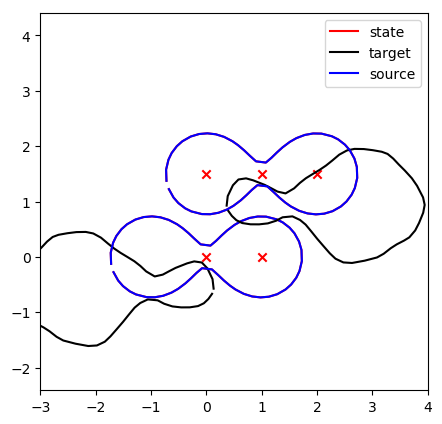

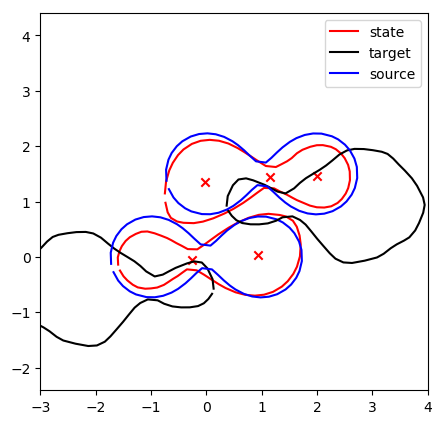

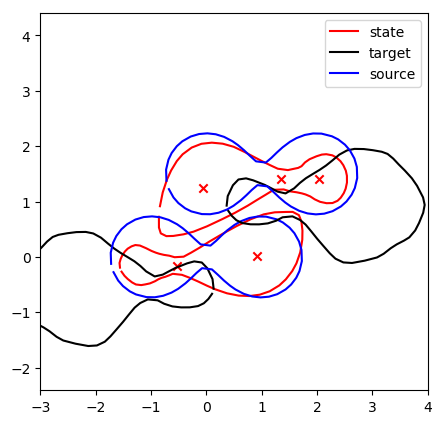

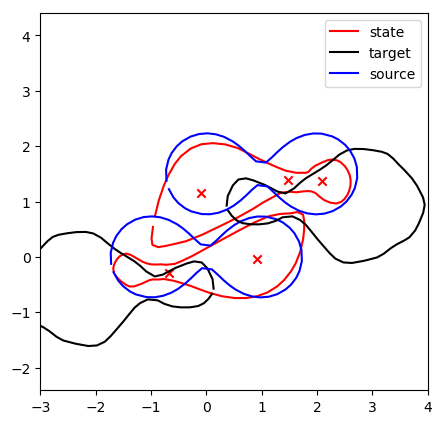

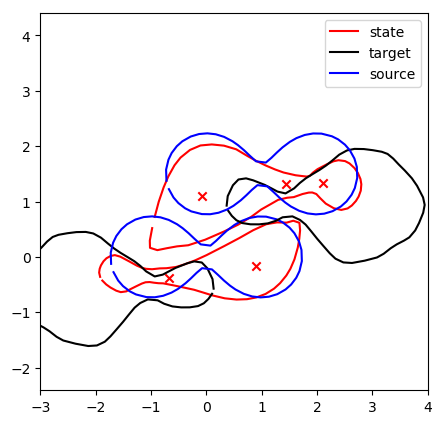

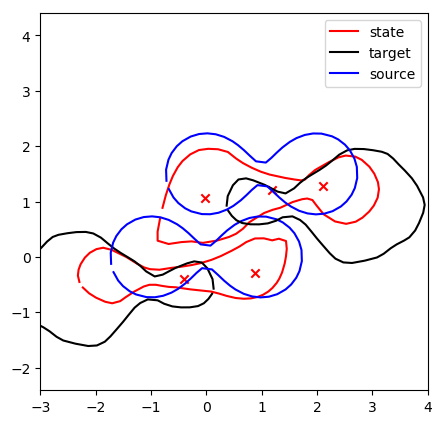

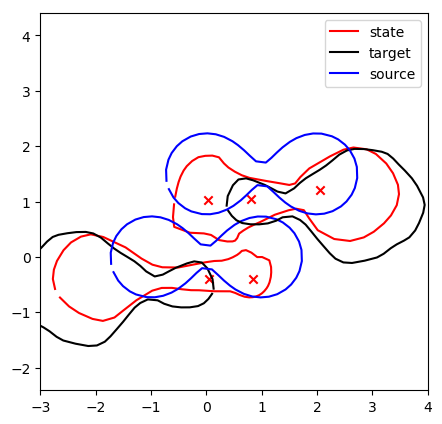

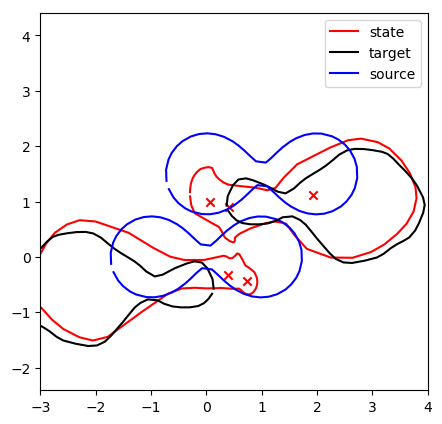

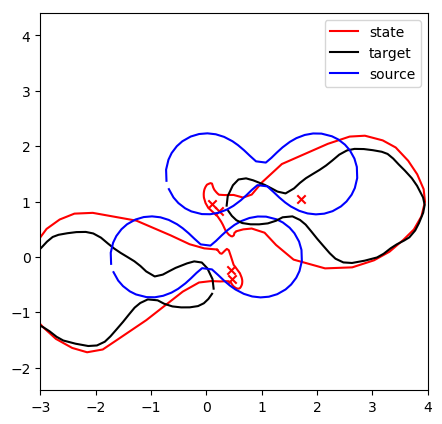

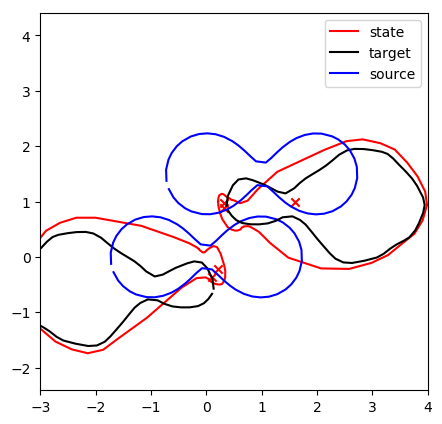

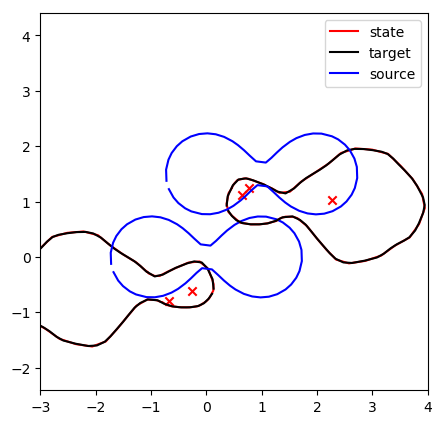

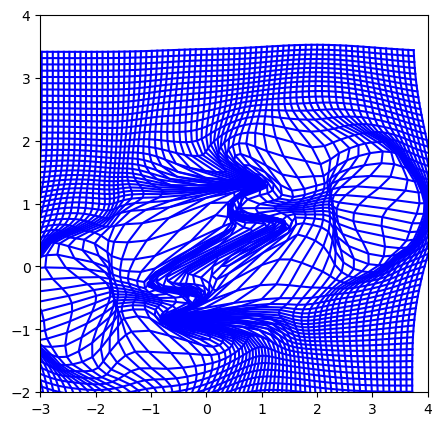

In [66]:
xlim = [-3, 4]
ylim = [-2,4]
d = [0.1, 0.1]
_ = save.gridpoints(xlim, ylim, d)
#save.fig_grid(True)

save.save('../results/Nuts-Multi/Compound/', axeslim=[*xlim, *ylim], plot_gd=['plot', 'plot', 'scatter',  'scatter', None, 'plot', 'scatter', 'scatter',  'scatter', None])
plt.close('all')

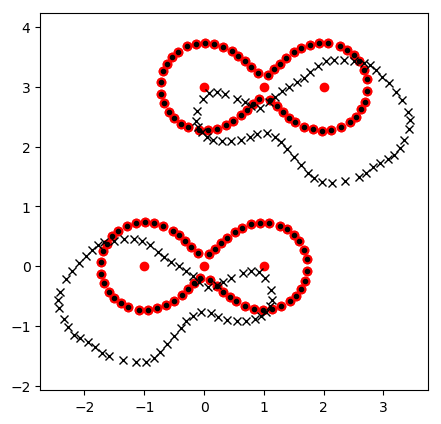

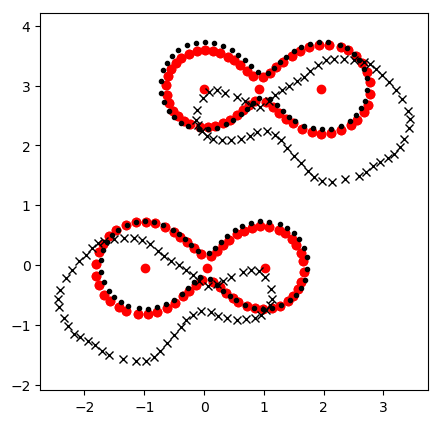

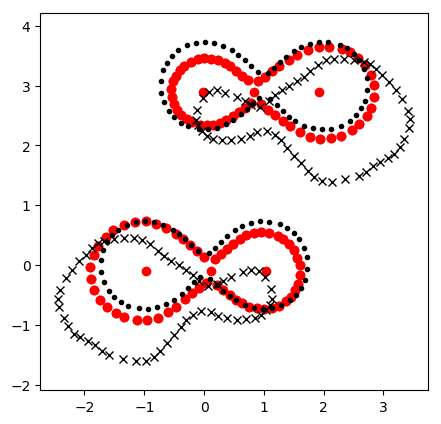

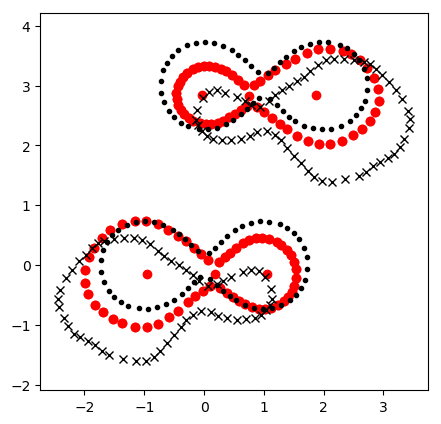

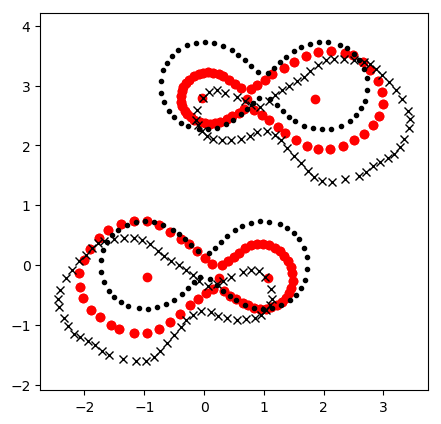

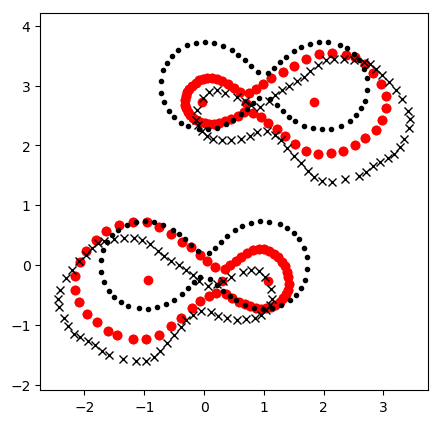

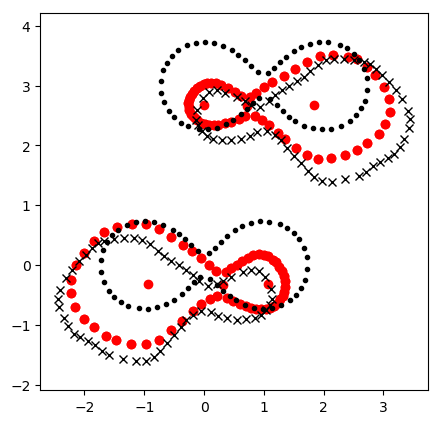

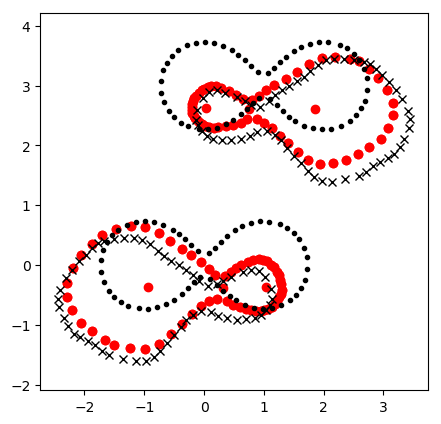

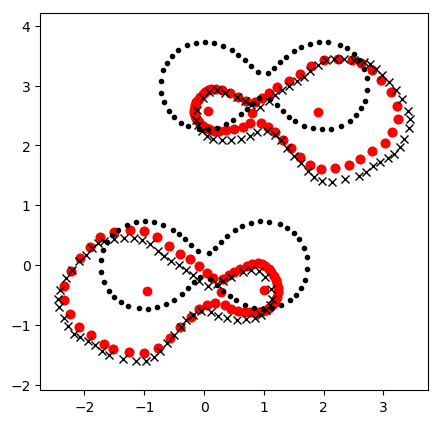

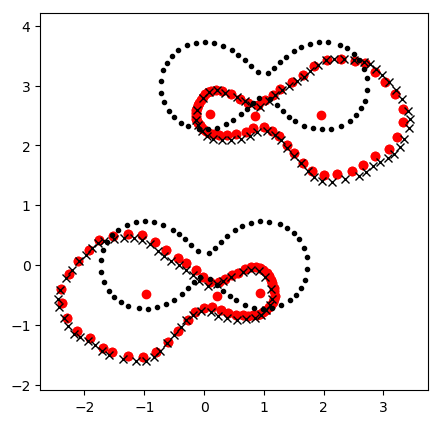

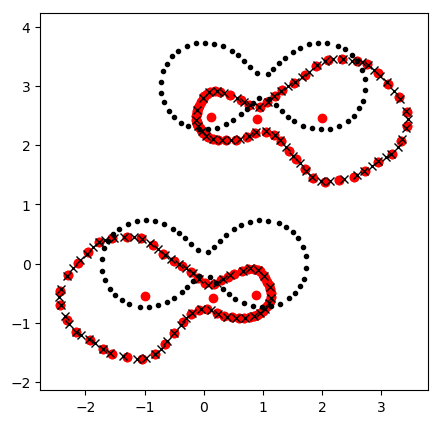

[<Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>]

In [68]:
save.fig_states(True)

In [40]:
H_compound.module.manifold.fill_gd(X_compound[0])
H_compound.module.manifold.fill_cotan(X_compound[1])
H_compound.geodesic_controls()
H_compound.module.controls

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


[tensor([], requires_grad=True),
 tensor([-8.4348], grad_fn=<MulBackward0>),
 tensor([0.2553], grad_fn=<MulBackward0>),
 tensor([-0.0866, -0.2444], grad_fn=<MulBackward0>),
 tensor([-0.1436,  0.1642, -0.1743,  0.2058, -0.1220, -0.7533, -0.0047,  0.9607,
         -0.3675, -1.1491,  0.1972,  1.1796, -0.4696, -0.9377,  0.4179,  0.7220,
         -0.8908, -0.2929,  0.1983,  0.1850,  0.3395, -0.5627, -0.8551,  0.2766,
          0.8183, -0.2050, -1.0127, -0.0916,  0.6084, -0.0439, -0.1573,  0.3410,
          0.0990, -0.2376, -0.4470,  0.3835,  0.5906, -0.3503, -0.7219,  0.1874,
          0.3059, -0.2450, -0.2597,  0.1569,  0.0528, -0.0418, -0.2109, -0.0018,
          0.1597,  0.2300, -0.1393, -0.3898, -0.3526,  0.0573,  0.6408,  0.7107,
         -0.3283, -0.7766,  0.0660,  0.4500, -0.1368, -0.2202, -0.1631,  0.0734,
         -0.1190,  0.0272, -0.0972,  0.1867, -0.0992,  0.0366, -0.1752,  0.1337,
          0.0081,  0.1708, -0.1401,  0.0766, -0.0028,  0.1492,  0.0290,  0.0403,
         -0.1456,

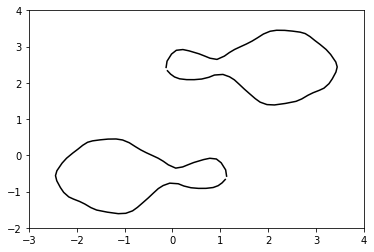

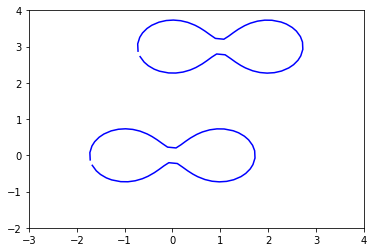

In [86]:
xlim = [-3, 4]
ylim = [-2,4]

fig_target = plt.figure()
plt_target = plt.plot(target[0][:,0].detach().numpy(), target[0][:, 1].detach().numpy(), c='k')
plt_target = plt.plot(target[1][:,0].detach().numpy(), target[1][:, 1].detach().numpy(), c='k')
#plt.legend((plt_target[0],),('target',))
axes = plt.gca()
axes.set_xlim(xlim)
axes.set_ylim(ylim)

fig_source = plt.figure()
plt_source = plt.plot(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='b')
plt_source = plt.plot(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='b')
#plt.legend(( plt_source[0],),('source',))
axes = plt.gca()
axes.set_xlim(xlim)
axes.set_ylim(ylim)
plt.show()

In [87]:
fig_source.savefig('../results/Nuts-Multi1/source.png')
fig_target.savefig('../results/Nuts-Multi1/target.png')

In [ ]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.geodesic_controls()
        return H()
    
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

gd = torch.cat(H.module.manifold.unroll_gd().copy()).requires_grad_().view(-1)
mom = torch.cat(H.module.manifold.unroll_cotan().copy()).requires_grad_().view(-1)


test_gradcheck_Hamiltonian()